<a href="https://colab.research.google.com/github/1587causalai/AboutCausalAI/blob/master/DiscoSCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ToyData4DiscoSCM


## Binary Treatment

### Quick Start

In [ ]:
# !pip install gpytorch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class toyData4DiscoSCM:
    def __init__(self, n=10000, seed=42):
        self.n = n

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def generate_data(self, full=False):
        # np.random.seed(self.seed)

        # 生成模拟数据
        X = np.random.choice([0, 1], size=self.n)
        T = X ^ np.random.choice([0, 1], size=self.n, p=[0.75, 0.25])
        W = np.random.normal(loc=0, scale=1, size=self.n)
        W = np.sign(W) * 4

        # 生成 potential noise and its selector
        index_selector = np.zeros((self.n, 2))
        for t in [0, 1]:
            index_selector[:, t] = 0 ^ np.random.binomial(1, self.sigmoid(W))

        index_selector = index_selector.astype(int)

        tmp_noise = np.random.normal(loc=0, scale=1, size=(self.n, 2))
        noise = np.zeros((self.n, 2))
        noise[np.arange(self.n), 0] =  tmp_noise[np.arange(self.n), index_selector[:, 0]] * np.sign(W)
        noise[np.arange(self.n), 1] =  tmp_noise[np.arange(self.n), index_selector[:, 1]]


        # 根据X的值生成 potential outcomes
        Y_full = np.zeros((self.n, 2))

        Y_full[X == 0, 0] =   0.1 * noise[np.arange(self.n)[X == 0], 0]
        Y_full[X == 0, 1] =   0.1 * noise[np.arange(self.n)[X == 0], 1]
        Y_full[X == 1, 0] =  0.5 + 0.1 * noise[np.arange(self.n)[X == 1], 0]
        Y_full[X == 1, 1] =  1.0 + 0.1 * noise[np.arange(self.n)[X == 1], 1]
        df = pd.DataFrame({'T': T, 'X': X, 'W': W, 'Y0': Y_full[:, 0], 'Y1': Y_full[:, 1]})
        df['Y'] = Y_full[np.arange(self.n), T]

        if full:
            return df
        else:
            return df[['T', 'X', 'W', 'Y']]

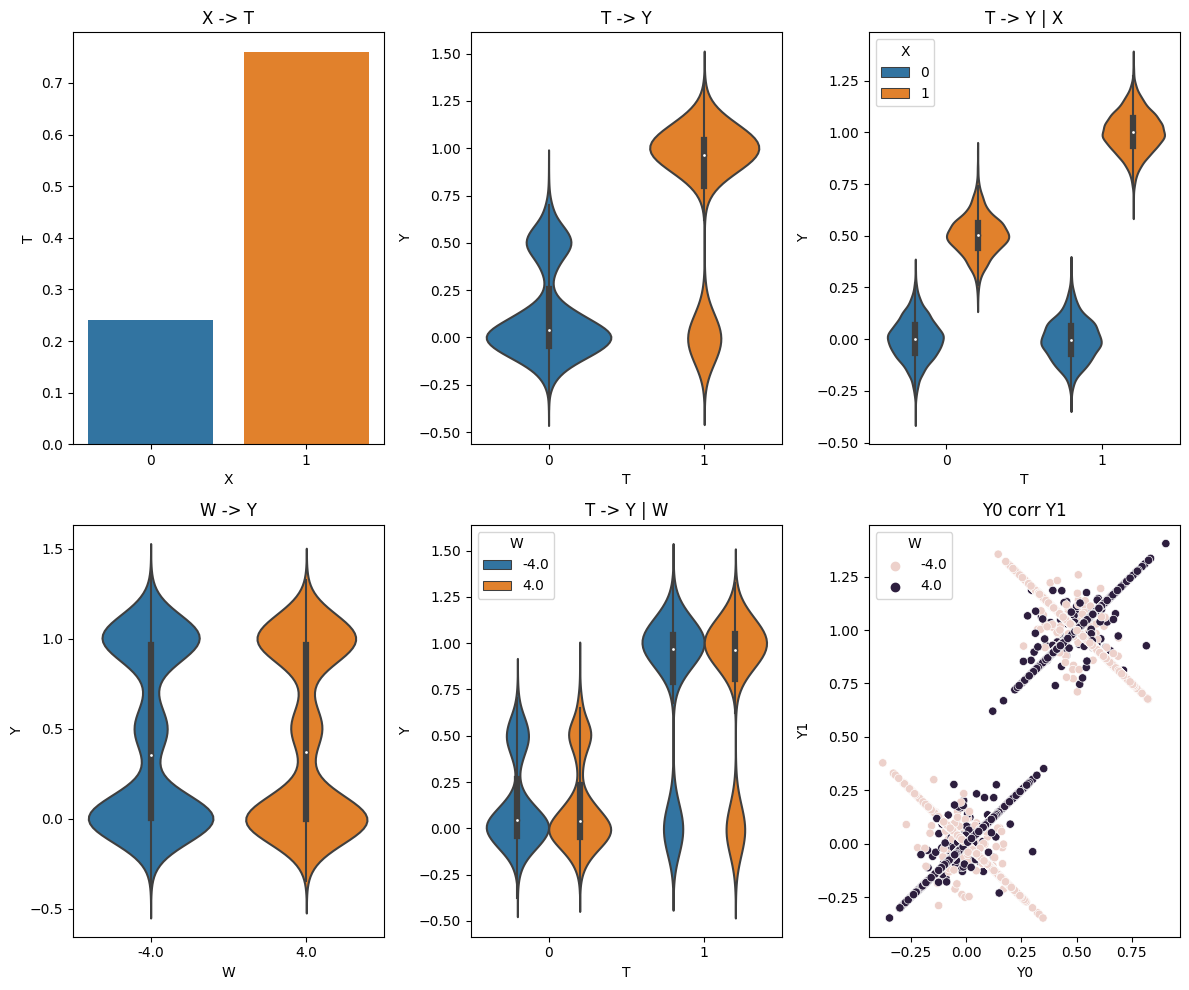

In [ ]:
def visualize(data):

    # 创建2x3图形布局
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))

    # 可视化 X -> T
    sns.barplot(x='X', y='T', errorbar=None, data=data, ax=axes[0, 0])
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('T')
    axes[0, 0].set_title('X -> T')


    # 可视化 T -> Y
    sns.violinplot(x='T', y='Y', data=data, ax=axes[0, 1])
    axes[0, 1].set_xlabel('T')
    axes[0, 1].set_ylabel('Y')
    axes[0, 1].set_title('T -> Y')

    # 可视化 T -> Y | X
    sns.violinplot(x='T', y='Y', hue='X', data=data, ax=axes[0, 2])
    axes[0, 2].set_xlabel('T')
    axes[0, 2].set_ylabel('Y')
    axes[0, 2].set_title('T -> Y | X')

    # 可视化 W -> Y
    sns.violinplot(x='W', y='Y', data=data, ax=axes[1, 0])
    axes[1, 0].set_xlabel('W')
    axes[1, 0].set_ylabel('Y')
    axes[1, 0].set_title('W -> Y')

    # 可视化 T -> Y | W
    sns.violinplot(x='T', y='Y', hue='W', data=data, ax=axes[1, 1])
    axes[1, 1].set_xlabel('T')
    axes[1, 1].set_ylabel('Y')
    axes[1, 1].set_title('T -> Y | W')


    # 可视化 Y0 corr Y1
    sns.scatterplot(x='Y0', y='Y1', hue='W', data=data, ax=axes[1, 2])
    axes[1, 2].set_xlabel('Y0')
    axes[1, 2].set_ylabel('Y1')
    axes[1, 2].set_title('Y0 corr Y1')


    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图形
    plt.show()



# 使用 toyData4DiscoSCM 类
toy_data = toyData4DiscoSCM(n=10000)

# 构建数据框
df = toy_data.generate_data(full=True)

# 使用数据调用可视化函数
visualize(df)

### End2End

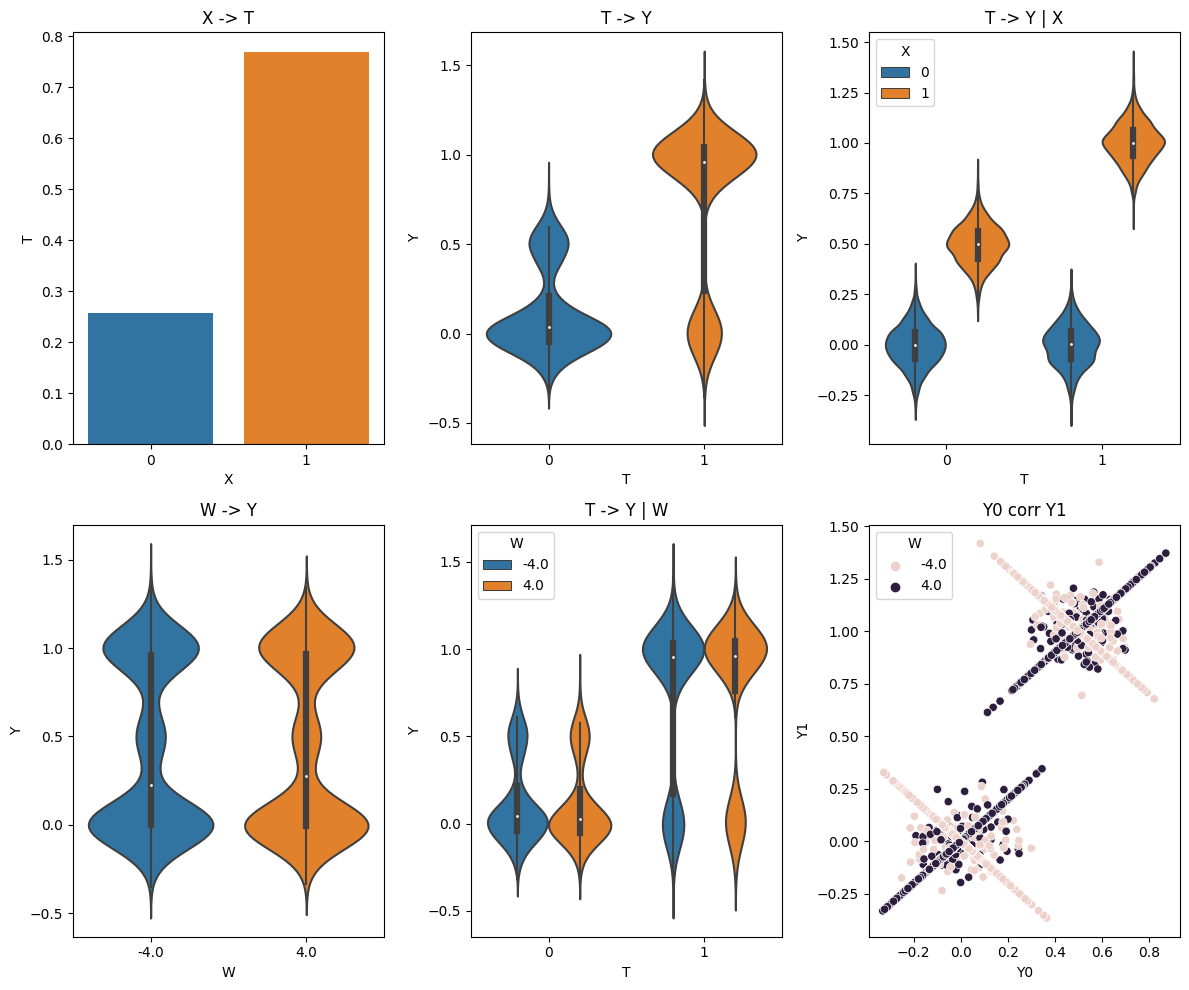

T  X    W        Y0        Y1         Y
0     1  1 -4.0  0.417347  1.082653  1.082653
1     1  1 -4.0  0.638193  0.861807  0.861807
2     0  0 -4.0  0.157539 -0.157539  0.157539
3     0  0  4.0  0.076383  0.076383  0.076383
4     1  1 -4.0  0.551791  0.948209  0.948209
...  .. ..  ...       ...       ...       ...
9995  0  0 -4.0  0.127585 -0.127585  0.127585
9996  0  0  4.0 -0.049181 -0.049181 -0.049181
9997  0  0  4.0  0.074564  0.074564  0.074564
9998  1  0 -4.0  0.108418 -0.108418 -0.108418
9999  0  0 -4.0  0.035225 -0.035225  0.035225

[10000 rows x 6 columns]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class BinaryT4DiscoSCM:
    def __init__(self, n=10000, seed=42):
        self.n = n

    def quickstart(self):
        df = self.generate_data()
        self.visualize(df)
        return df


    def generate_data(self, full=True, disco=True):
        X = np.random.choice([0, 1], size=self.n)
        T = X ^ np.random.choice([0, 1], size=self.n, p=[0.75, 0.25])
        W = np.random.normal(loc=0, scale=1, size=self.n)
        W = np.sign(W) * 4

        index_selector = np.zeros((self.n, 2))
        for t in [0, 1]:
            index_selector[:, t] = 0 ^ np.random.binomial(1, self.sigmoid(W))
        index_selector = index_selector.astype(int)

        tmp_noise = np.random.normal(loc=0, scale=1, size=(self.n, 2))
        noise = np.zeros((self.n, 2))
        noise[np.arange(self.n), 0] =  tmp_noise[np.arange(self.n), index_selector[:, 0]] * np.sign(W)
        noise[np.arange(self.n), 1] =  tmp_noise[np.arange(self.n), index_selector[:, 1]]
        if not disco:
            noise = tmp_noise

        Y_full = np.zeros((self.n, 2))
        Y_full[X == 0, 0] =   0.1 * noise[np.arange(self.n)[X == 0], 0]
        Y_full[X == 0, 1] =   0.1 * noise[np.arange(self.n)[X == 0], 1]
        Y_full[X == 1, 0] =  0.5 + 0.1 * noise[np.arange(self.n)[X == 1], 0]
        Y_full[X == 1, 1] =  1.0 + 0.1 * noise[np.arange(self.n)[X == 1], 1]
        df = pd.DataFrame({'T': T, 'X': X, 'W': W, 'Y0': Y_full[:, 0], 'Y1': Y_full[:, 1]})
        df['Y'] = Y_full[np.arange(self.n), T]

        if full:
            return df
        else:
            return df[['T', 'X', 'W', 'Y']]

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def visualize(data):
        fig, axes = plt.subplots(2, 3, figsize=(12, 10))
        sns.barplot(x='X', y='T', errorbar=None, data=data, ax=axes[0, 0])
        axes[0, 0].set_title('X -> T')
        sns.violinplot(x='T', y='Y', data=data, ax=axes[0, 1])
        axes[0, 1].set_title('T -> Y')
        sns.violinplot(x='T', y='Y', hue='X', data=data, ax=axes[0, 2])
        axes[0, 2].set_title('T -> Y | X')
        sns.violinplot(x='W', y='Y', data=data, ax=axes[1, 0])
        axes[1, 0].set_title('W -> Y')
        sns.violinplot(x='T', y='Y', hue='W', data=data, ax=axes[1, 1])
        axes[1, 1].set_title('T -> Y | W')
        sns.scatterplot(x='Y0', y='Y1', hue='W', data=data, ax=axes[1, 2])
        axes[1, 2].set_title('Y0 corr Y1')
        plt.tight_layout()
        plt.show()

# 使用 binaryT4DiscoSCM 类
g = BinaryT4DiscoSCM(n=10000)

# 使用数据调用可视化函数
g.quickstart()


### 🔥Zero2All


数据生成 for binary treatment

- rct 表示是否随机试验数据
- disco 表示是否存在potential noise 之间相关性


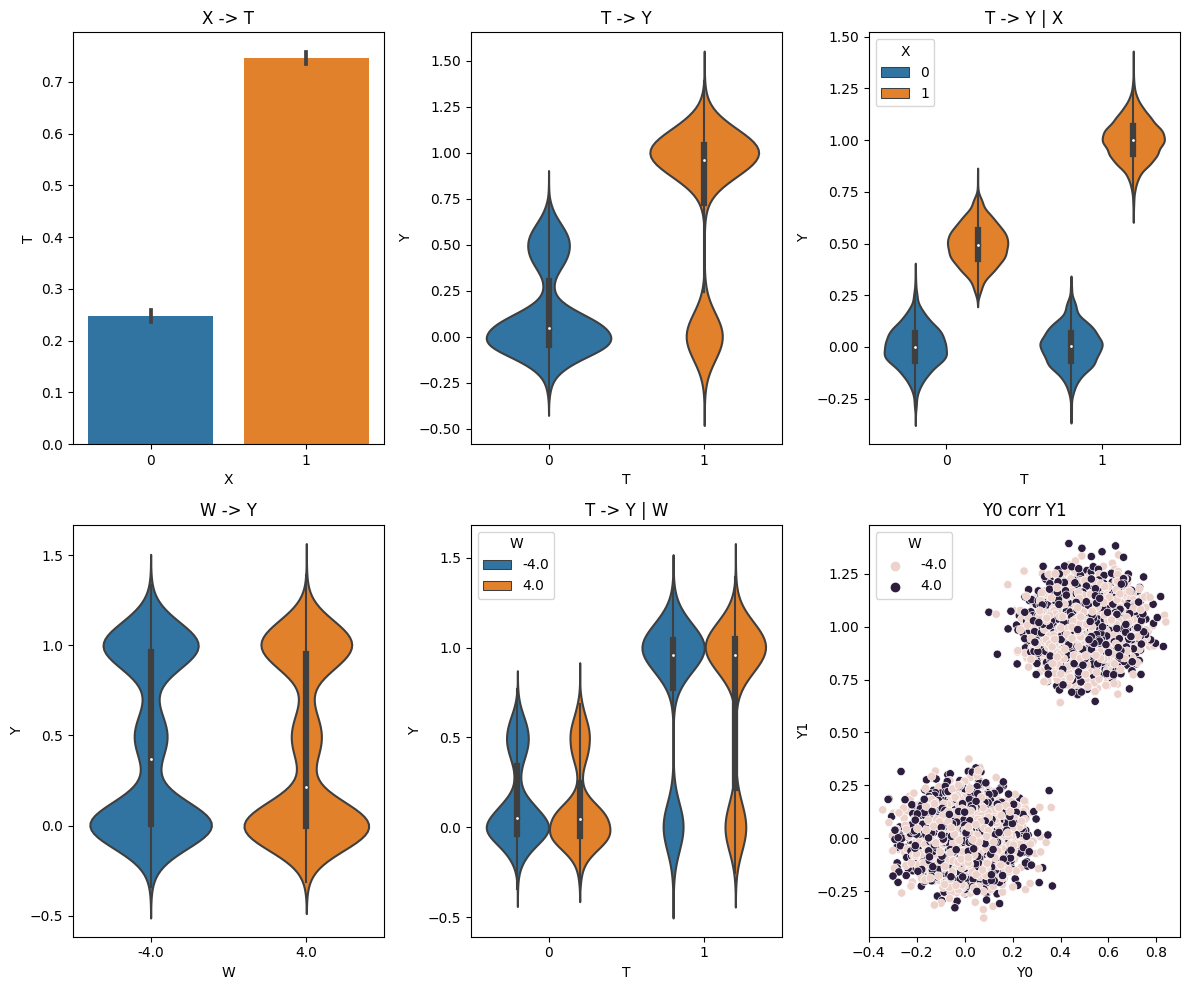

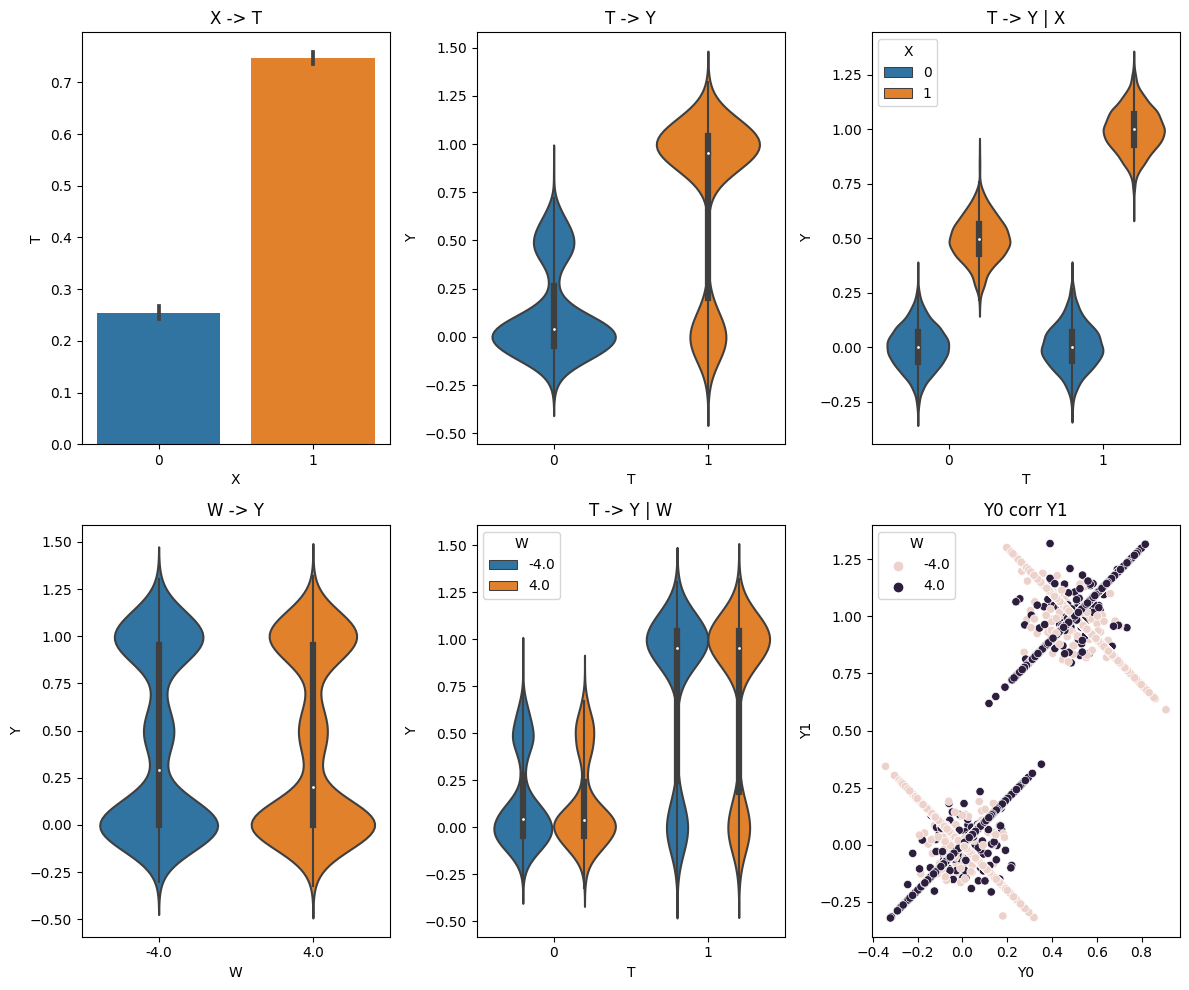

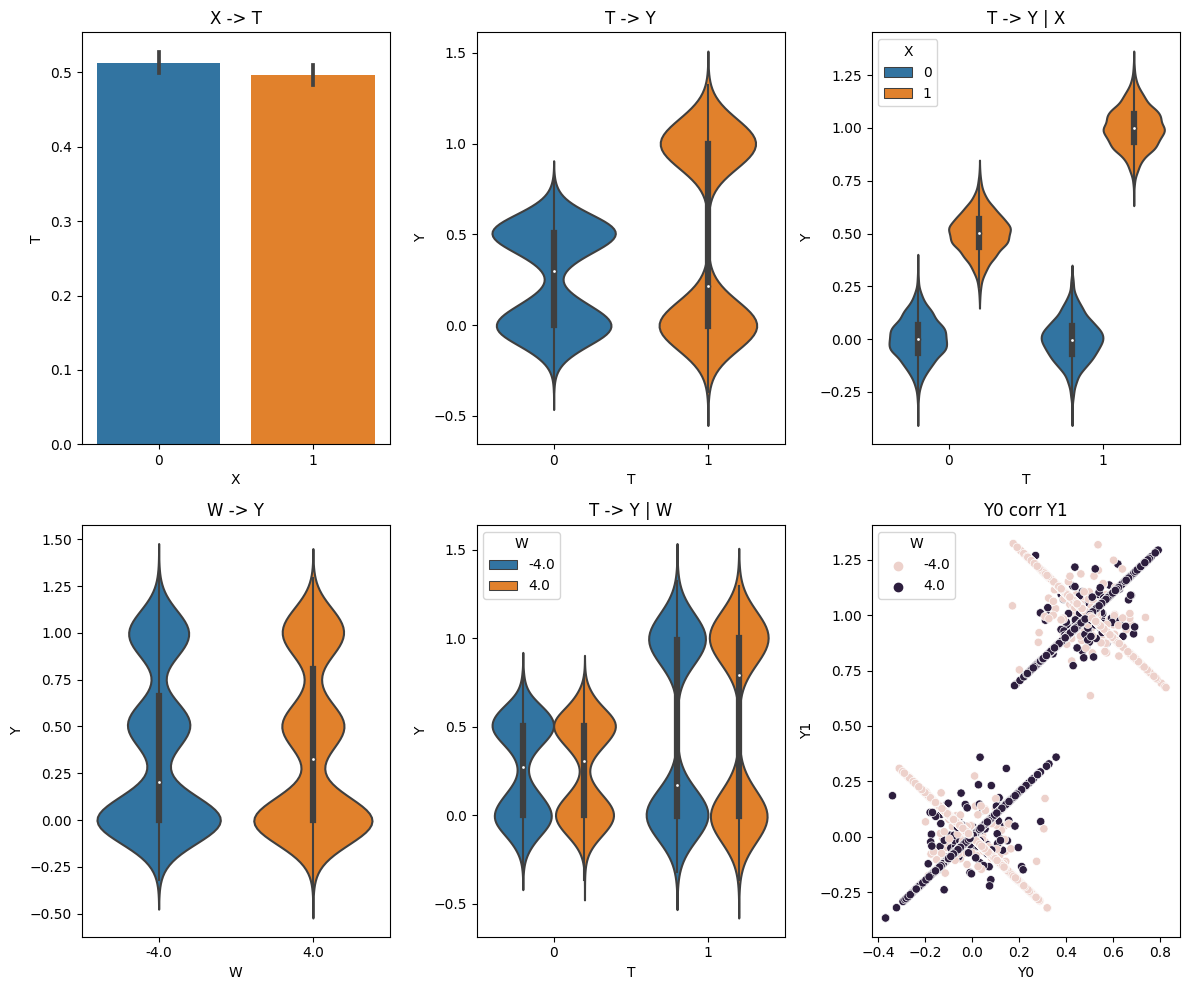

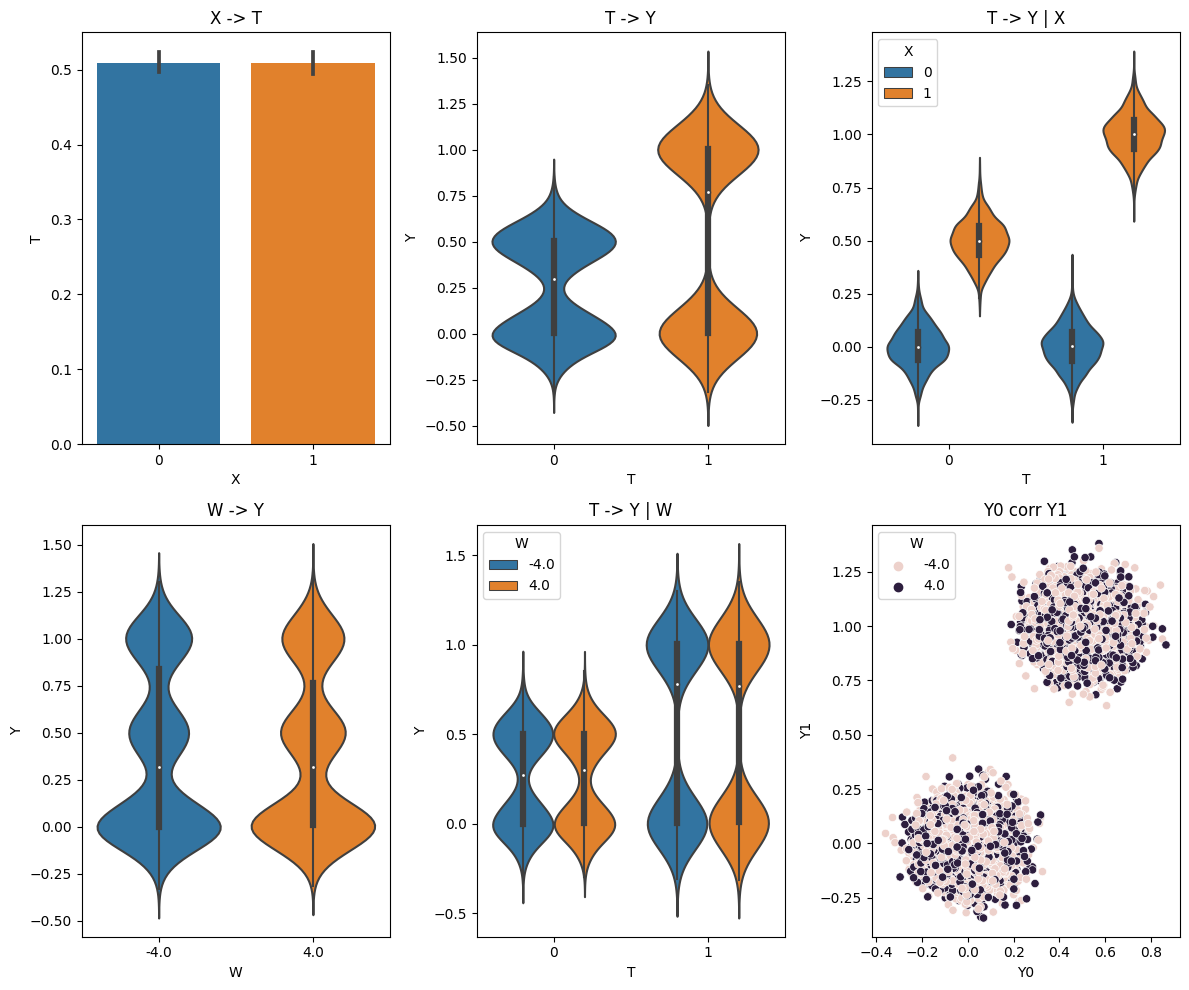

T  X    W        Y0        Y1         Y
0     1  1  4.0  0.503666  0.991884  0.991884
1     0  0  4.0 -0.042182 -0.061008 -0.042182
2     1  0  4.0  0.041090  0.166085  0.166085
3     0  0 -4.0 -0.014992 -0.077162 -0.014992
4     0  0 -4.0 -0.053855  0.085862 -0.053855
...  .. ..  ...       ...       ...       ...
9995  1  0 -4.0  0.113930  0.055567  0.055567
9996  1  1 -4.0  0.403625  1.103164  1.103164
9997  0  1  4.0  0.361758  0.882931  0.361758
9998  1  0  4.0  0.050467 -0.114090 -0.114090
9999  0  1  4.0  0.614277  1.069742  0.614277

[10000 rows x 6 columns]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class BinaryT4DiscoSCM:
    def __init__(self, n=10000, seed=42):
        self.n = n

    def quickstart(self, *args, **kwargs):
        df = self.generate_data(*args, **kwargs)
        self.visualize(df)
        return df


    def generate_data(self, full=True, disco=True, rct=False):
        X = np.random.choice([0, 1], size=self.n)
        T = X ^ np.random.choice([0, 1], size=self.n, p=[0.75, 0.25])
        if rct:
            T = np.random.choice([0, 1], size=self.n, p=[0.5, 0.5])
        W = np.random.normal(loc=0, scale=1, size=self.n)
        W = np.sign(W) * 4

        index_selector = np.zeros((self.n, 2))
        for t in [0, 1]:
            index_selector[:, t] = 0 ^ np.random.binomial(1, self.sigmoid(W))
        index_selector = index_selector.astype(int)

        tmp_noise = np.random.normal(loc=0, scale=1, size=(self.n, 2))
        noise = np.zeros((self.n, 2))
        noise[np.arange(self.n), 0] =  tmp_noise[np.arange(self.n), index_selector[:, 0]] * np.sign(W)
        noise[np.arange(self.n), 1] =  tmp_noise[np.arange(self.n), index_selector[:, 1]]
        if not disco:
            noise = tmp_noise

        Y_full = np.zeros((self.n, 2))
        Y_full[X == 0, 0] =   0.1 * noise[np.arange(self.n)[X == 0], 0]
        Y_full[X == 0, 1] =   0.1 * noise[np.arange(self.n)[X == 0], 1]
        Y_full[X == 1, 0] =  0.5 + 0.1 * noise[np.arange(self.n)[X == 1], 0]
        Y_full[X == 1, 1] =  1.0 + 0.1 * noise[np.arange(self.n)[X == 1], 1]
        df = pd.DataFrame({'T': T, 'X': X, 'W': W, 'Y0': Y_full[:, 0], 'Y1': Y_full[:, 1]})
        df['Y'] = Y_full[np.arange(self.n), T]

        if full:
            return df
        else:
            return df[['T', 'X', 'W', 'Y']]

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def visualize(data):
        fig, axes = plt.subplots(2, 3, figsize=(12, 10))
        sns.barplot(x='X', y='T', data=data, ax=axes[0, 0])
        axes[0, 0].set_title('X -> T')
        sns.violinplot(x='T', y='Y', data=data, ax=axes[0, 1])
        axes[0, 1].set_title('T -> Y')
        sns.violinplot(x='T', y='Y', hue='X', data=data, ax=axes[0, 2])
        axes[0, 2].set_title('T -> Y | X')
        sns.violinplot(x='W', y='Y', data=data, ax=axes[1, 0])
        axes[1, 0].set_title('W -> Y')
        sns.violinplot(x='T', y='Y', hue='W', data=data, ax=axes[1, 1])
        axes[1, 1].set_title('T -> Y | W')
        sns.scatterplot(x='Y0', y='Y1', hue='W', data=data, ax=axes[1, 2])
        axes[1, 2].set_title('Y0 corr Y1')
        plt.tight_layout()
        plt.show()

# 使用 binaryT4DiscoSCM 类
g = BinaryT4DiscoSCM(n=10000)

# 使用数据调用可视化函数
g.quickstart(disco=False)
g.quickstart(disco=True)
g.quickstart(disco=True, rct=True)
g.quickstart(disco=False, rct=True)

## 🔥Multiple Treatment

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

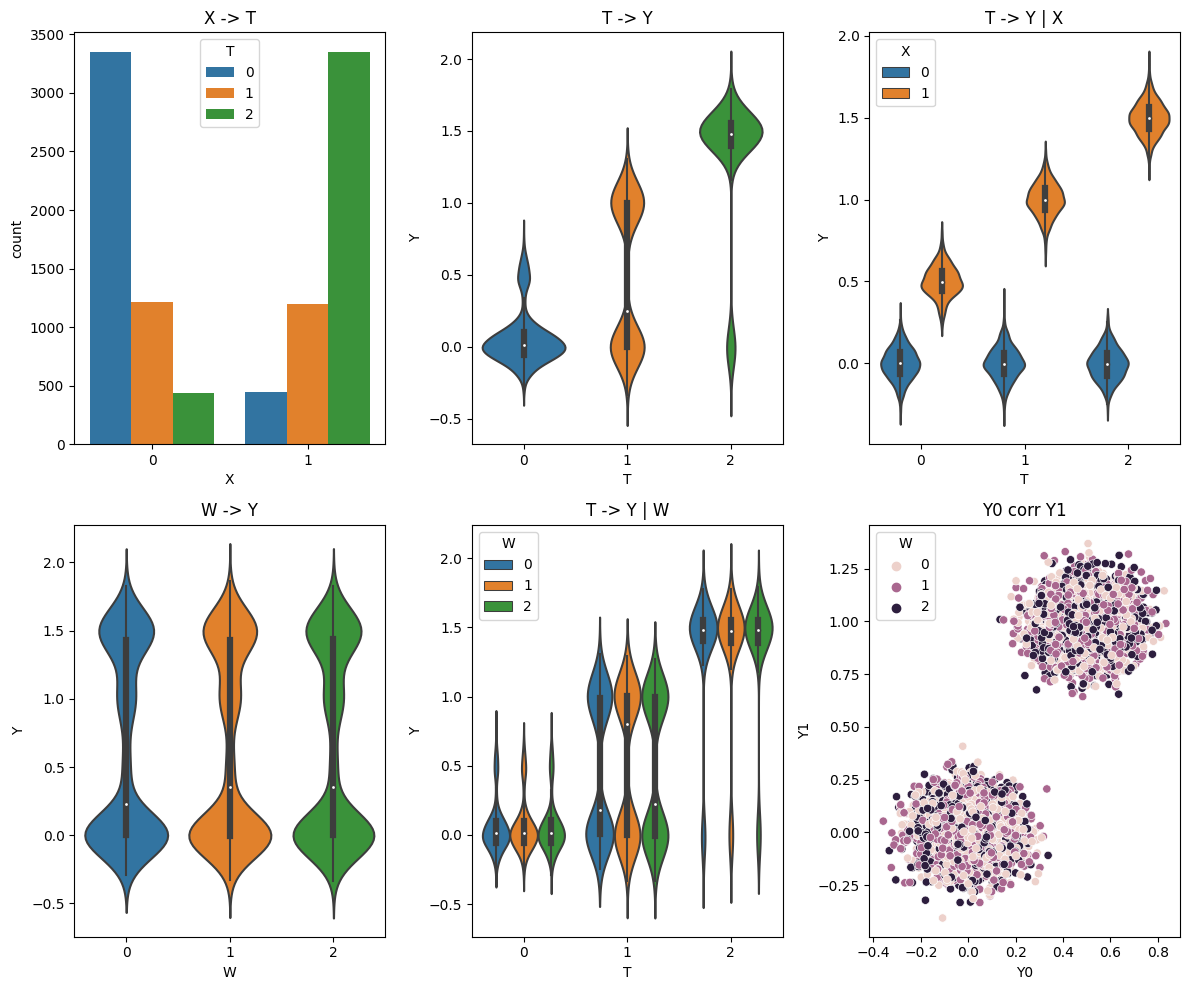

T  X  W         Y        Y0        Y1        Y2
0     2  0  0 -0.045813  0.027310 -0.157432 -0.045813
1     1  0  1 -0.012703  0.070040 -0.012703 -0.086604
2     2  1  0  1.455697  0.618787  1.053283  1.455697
3     1  1  2  1.091963  0.657804  1.091963  1.478813
4     2  1  0  1.477763  0.562539  1.097428  1.477763
...  .. .. ..       ...       ...       ...       ...
9995  0  0  2  0.247418  0.247418  0.135449 -0.064263
9996  2  0  1 -0.000021  0.118468  0.073858 -0.000021
9997  0  1  2  0.555974  0.555974  0.868035  1.559119
9998  1  1  2  0.995991  0.544647  0.995991  1.598058
9999  2  1  2  1.365743  0.523317  0.761406  1.365743

[10000 rows x 7 columns]

In [ ]:
class MultiValueT4DiscoSCM:
    def __init__(self, n=10000, seed=42, num_treatments=3):
        self.n = n
        self.num_treatments = num_treatments

    def quickstart(self, *args, **kwargs):
        df = self.generate_data(*args, **kwargs)
        self.visualize(df)
        return df

    def generate_data(self, full=True, disco=True, rct=False):
        X = np.random.choice([0, 1], size=self.n)
        # Update T to be a multivalue random variable.
        T = np.random.choice(np.arange(self.num_treatments), size=self.n)
        T_probs_X1 = self.softmax(np.arange(self.num_treatments) * 1)
        T_probs_X0 = T_probs_X1[::-1]  # reverse of T_probs_X1
        if not rct:
            T[X==0] = np.random.choice(np.arange(self.num_treatments), size=(X==0).sum(), p=T_probs_X0)
            T[X==1] = np.random.choice(np.arange(self.num_treatments), size=(X==1).sum(), p=T_probs_X1)

        W = np.random.choice(np.arange(self.num_treatments), size=self.n)


        index_selector = np.zeros((self.n, self.num_treatments), dtype=int)

        for t in range(self.num_treatments):
            rand_t = np.random.choice(np.arange(self.num_treatments), size=self.n)
            w_selector =  np.random.choice([0, 1], size=self.n, p=[0.05, 0.95])
            w_ind = W * w_selector + rand_t * (1 - w_selector)
            index_selector[:, t] = np.mod(0 + w_ind, self.num_treatments)

        index_selector = index_selector.astype(int)

        tmp_noise = np.random.normal(loc=0, scale=1, size=(self.n, self.num_treatments))
        noise = np.zeros((self.n, self.num_treatments))
        for t in range(self.num_treatments):
            noise[np.arange(self.n), t] =  tmp_noise[np.arange(self.n), index_selector[:, t]]
            if t == 0:
                noise[np.arange(self.n), t] = noise[np.arange(self.n), t] * np.sign(1.0 - 2*(W==0))
        if not disco:
            noise = tmp_noise

        Y_full = np.zeros((self.n, self.num_treatments))
        for t in range(self.num_treatments):
            Y_full[X == 0, t] =  0.1 * noise[np.arange(self.n)[X == 0], t]
            Y_full[X == 1, t] =  (t+1) * 0.5 + 0.1 * noise[np.arange(self.n)[X == 1], t]
        df = pd.DataFrame({'T': T, 'X': X, 'W': W, 'Y': Y_full[np.arange(self.n), T]})

        for i in range(self.num_treatments):
            df[f'Y{i}'] = Y_full[:, i]

        if full:
            return df
        else:
            return df[['T', 'X', 'W', 'Y']]

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    @staticmethod
    def visualize(data):
        fig, axes = plt.subplots(2, 3, figsize=(12, 10))
        sns.countplot(x='X', hue='T', data=data, ax=axes[0, 0])
        axes[0, 0].set_title('X -> T')
        sns.violinplot(x='T', y='Y', data=data, ax=axes[0, 1])
        axes[0, 1].set_title('T -> Y')
        sns.violinplot(x='T', y='Y', hue='X', data=data, ax=axes[0, 2])
        axes[0, 2].set_title('T -> Y | X')
        sns.violinplot(x='W', y='Y', data=data, ax=axes[1, 0])
        axes[1, 0].set_title('W -> Y')
        sns.violinplot(x='T', y='Y', hue='W', data=data, ax=axes[1, 1])
        axes[1, 1].set_title('T -> Y | W')
        sns.scatterplot(x='Y0', y='Y1', hue='W', data=data, ax=axes[1, 2])
        axes[1, 2].set_title('Y0 corr Y1')
        plt.tight_layout()
        plt.show()

g = MultiValueT4DiscoSCM(n=10000, num_treatments=3)
g.quickstart(disco=False)


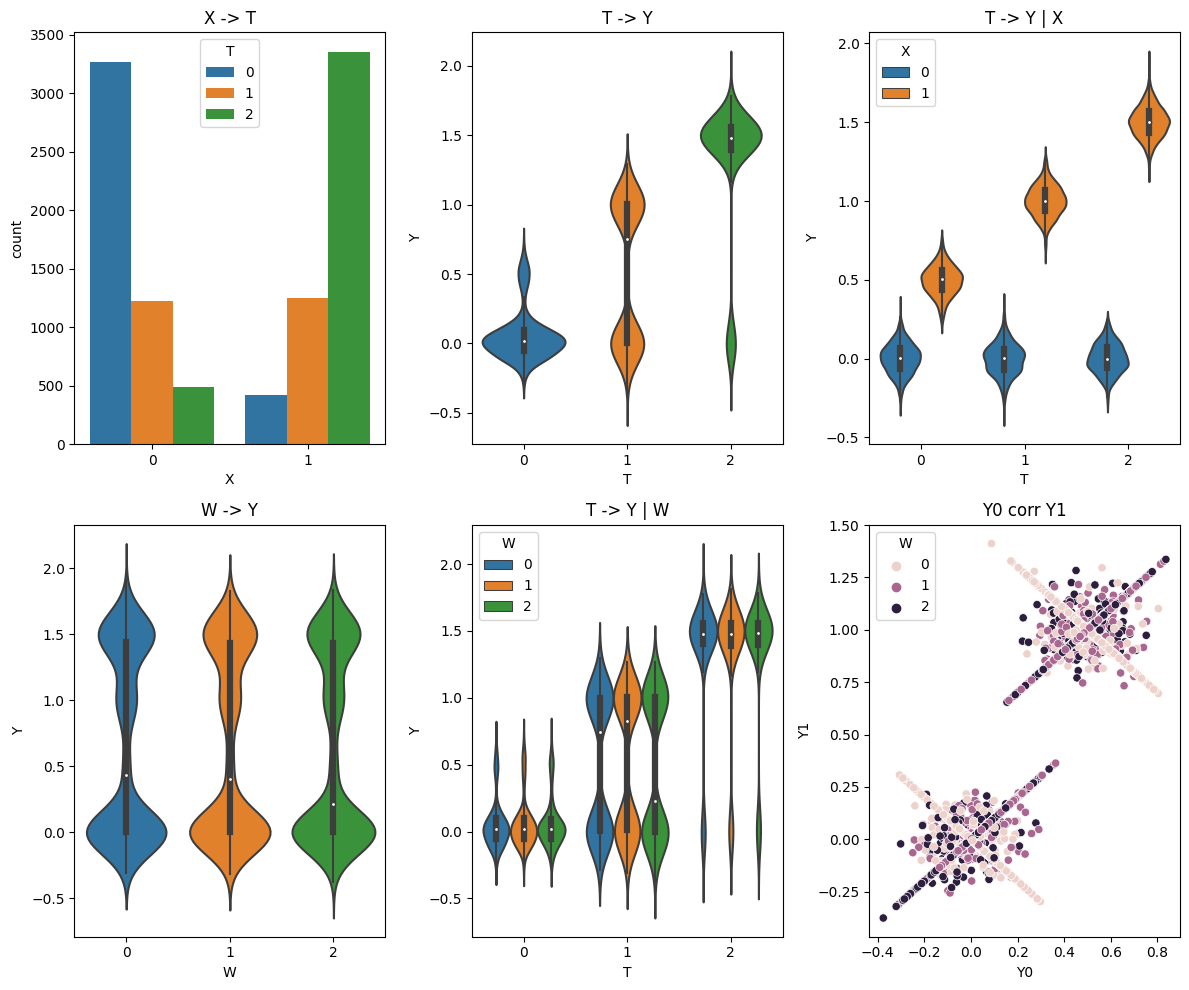

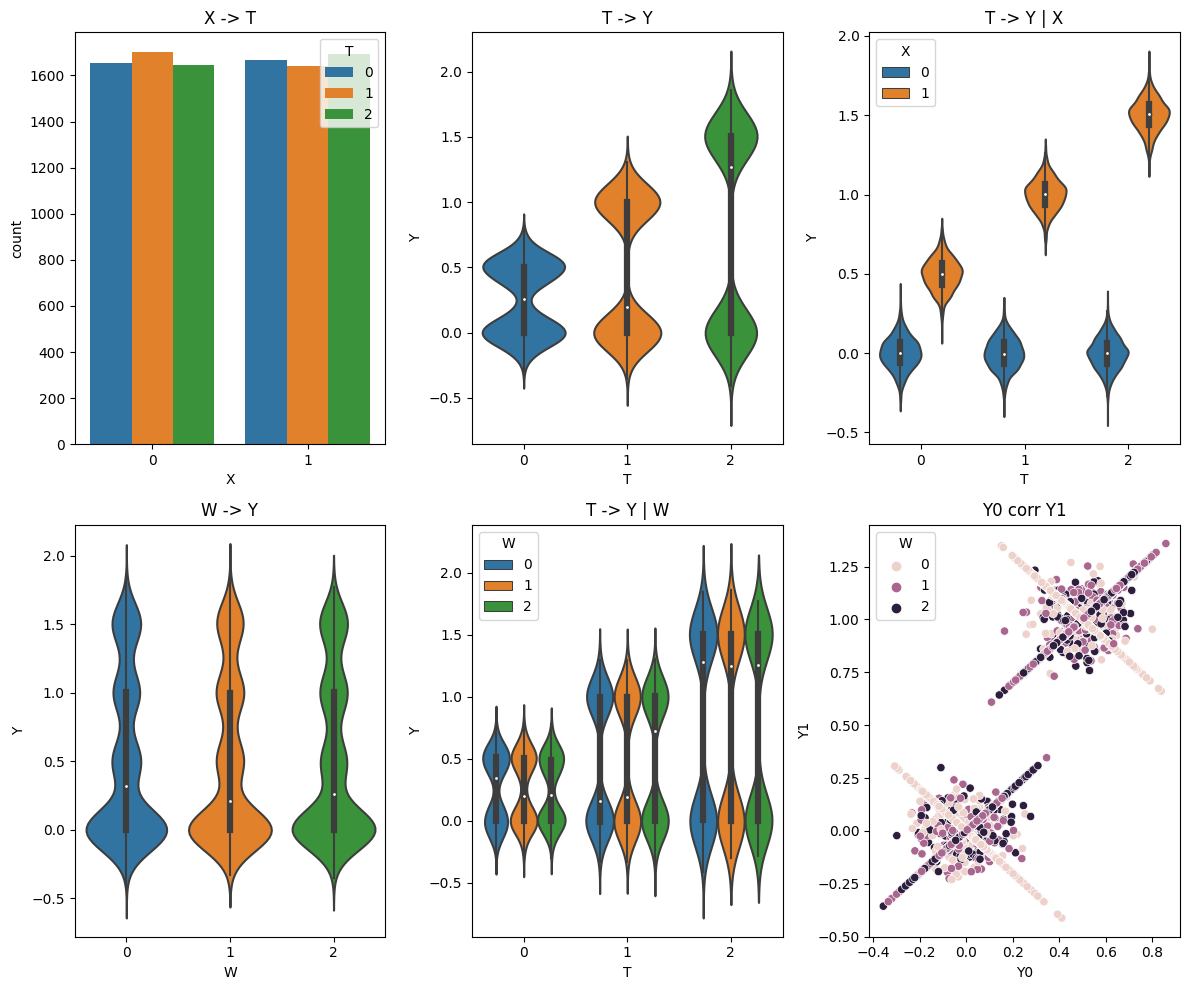

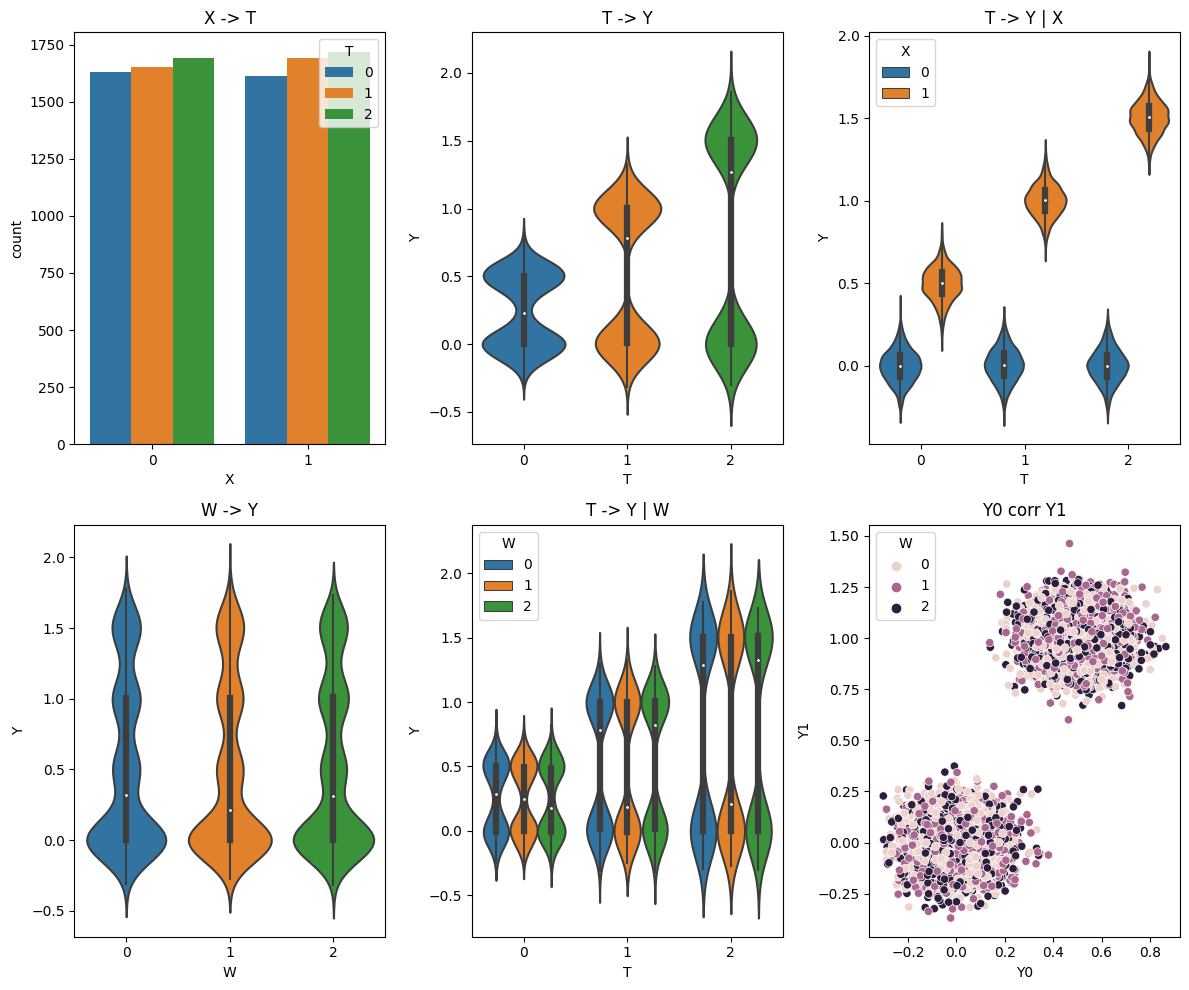

T  X  W         Y        Y0        Y1        Y2
0     0  1  0  0.598751  0.598751  1.102734  1.603913
1     1  1  0  0.953175  0.659415  0.953175  1.441523
2     0  0  1 -0.120359 -0.120359 -0.015561  0.098778
3     2  1  1  1.570003  0.524271  1.024121  1.570003
4     1  0  0 -0.008883 -0.073707 -0.008883  0.098235
...  .. .. ..       ...       ...       ...       ...
9995  1  1  0  1.030884  0.486135  1.030884  1.495121
9996  0  1  1  0.328591  0.328591  0.895637  1.565136
9997  0  0  2  0.015645  0.015645  0.000045 -0.121652
9998  0  0  1 -0.234824 -0.234824 -0.134602 -0.078224
9999  2  1  2  1.540970  0.305082  0.851002  1.540970

[10000 rows x 7 columns]

In [ ]:

g.quickstart(disco=True, rct=False)
g.quickstart(disco=True, rct=True)
g.quickstart(disco=False, rct=True)


# DiscoSCM 模型

## QuickStart

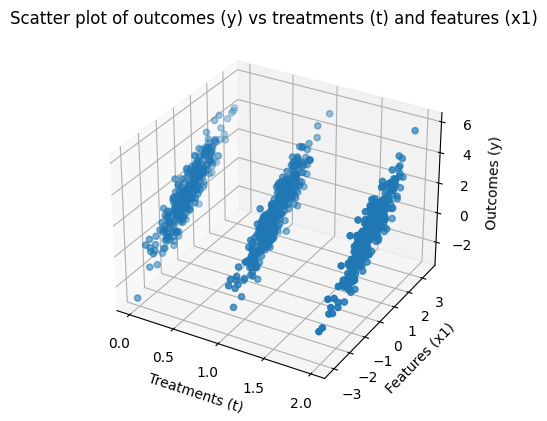

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class MultipleT4DiscoSCM(nn.Module):
    def __init__(self, n=1000, num_treatments=3, p=2, hidden_size=1, seed=42):
        super(MultipleT4DiscoSCM, self).__init__()
        self.n = n
        self.num_treatments = num_treatments
        self.num_features = p
        torch.manual_seed(seed)
        self.mean_net = nn.Sequential(
            nn.Linear(p + num_treatments, hidden_size),
            nn.Linear(hidden_size, 1)
        )
        self.coef_net = nn.Parameter(torch.tensor(1.0))

        # Initialize selector_matrix as learnable parameter
        self.selector_matrix = nn.Parameter(torch.rand(num_treatments, num_treatments))

    def forward(self, x):

        num_samples = x.size(0)

        # Step 1: Get the num_treatments * num_treatments matrix
        selector_output = self.selector_matrix.unsqueeze(0).expand(num_samples, -1, -1)
        probabilities = F.softmax(selector_output, dim=2)

        # Step 2: Sampling indices s(t)
        s_t = torch.multinomial(probabilities.view(num_samples * self.num_treatments, -1), 1)
        s_t = s_t.view(num_samples, self.num_treatments)

        # Step 2: Get noise e and e'
        e = torch.randn(num_samples, self.num_treatments)
        e_prime = torch.gather(e, 1, s_t)

        # Step 3: Calculate the final y using matrix operations
        t_one_hot = torch.eye(self.num_treatments).unsqueeze(0).expand(num_samples, -1, -1).to(x.device)
        x_t = torch.cat([x.unsqueeze(1).expand(-1, self.num_treatments, -1), t_one_hot], dim=2)

        mean_output = self.mean_net(x_t.view(-1, x_t.size(-1))).view(num_samples, self.num_treatments)
        coef_output = self.coef_net
        y = mean_output + coef_output * e_prime

        return y

    def predict(self, x, t):
        """posterior to obtain the observations.
        """
        # Forward pass
        y_pred = self.forward(x)

        # Select the outcomes corresponding to the treatments
        t_indices = t.view(-1, 1).long()
        y_pred_t = torch.gather(y_pred, 1, t_indices)

        return y_pred_t


    def scm_data(self):
        x = torch.randn(self.n, self.num_features)
        t = torch.randint(0, self.num_treatments, (self.n, 1)).float()
        w = torch.rand(self.num_features, 1)
        b = torch.rand(self.num_treatments, 1).cumsum(dim=0) * 2

        noise_std = 0.1
        e = torch.randn(self.n, 1) * noise_std
        y = x @ w + torch.gather(b, 0, t.long()) + e

        return x, t, y, w, b

    @staticmethod
    def scatter_plot_3d(x, t, y):
        t_np = t.numpy()
        x_np = x.numpy()
        y_np = y.numpy()
        x1 = x_np[:, 0]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(t_np, x1, y_np)
        ax.set_xlabel("Treatments (t)")
        ax.set_ylabel("Features (x1)")
        ax.set_zlabel("Outcomes (y)")
        plt.title("Scatter plot of outcomes (y) vs treatments (t) and features (x1)")
        plt.show()
    @staticmethod
    def scatter_plot_true_vs_predicted(y_test, y_pred_t_test):
        y_test_np = y_test.numpy()
        y_pred_t_test_np = y_pred_t_test.detach().numpy()

        plt.scatter(y_test_np, y_pred_t_test_np)
        plt.xlabel("True Outcomes")
        plt.ylabel("Predicted Outcomes")
        plt.title("True vs Predicted Outcomes")
        plt.show()


g = MultipleT4DiscoSCM()
x, t, y, w, b = g.scm_data()
g.scatter_plot_3d(x, t, y)

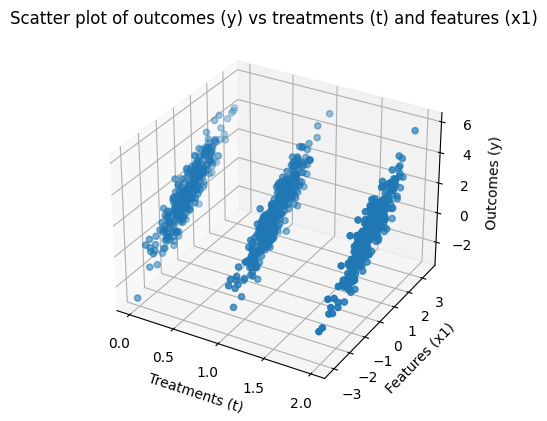

The Noise Selector:
 Parameter containing:
tensor([[0.9408, 0.1332, 0.9346],
        [0.5936, 0.8694, 0.5677],
        [0.7411, 0.4294, 0.8854]], requires_grad=True)
Epoch 1/400, Loss: 4.573195838928223
Epoch 51/400, Loss: 1.5692734241485595
Epoch 101/400, Loss: 0.0494031623005867
Epoch 151/400, Loss: 0.011525590494275094
Epoch 201/400, Loss: 0.010156715512275696
Epoch 251/400, Loss: 0.010119189321994782
Epoch 301/400, Loss: 0.010122031643986703
Epoch 351/400, Loss: 0.010115788504481315


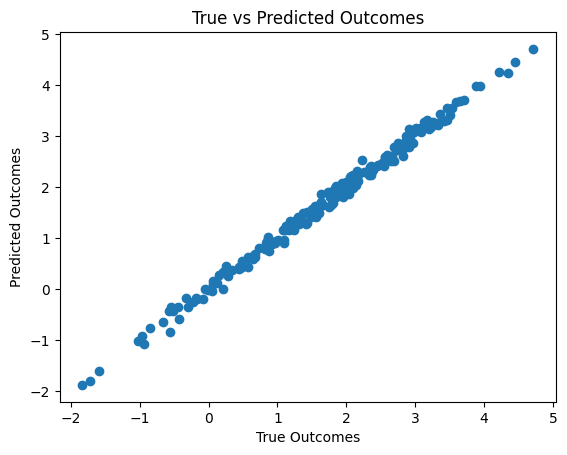

In [ ]:
def train(model, x_train, t_train, y_train, epochs=400, learning_rate=0.001, batch_size=64):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    n = x_train.size(0)

    for epoch in range(epochs):
        epoch_loss = 0.0

        for i in range(0, n, batch_size):
            batch_x = x_train[i:i + batch_size]
            batch_t = t_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]

            optimizer.zero_grad()

            y_pred = model(batch_x)

            t_indices = batch_t.view(-1, 1).long()
            y_pred_t = torch.gather(y_pred, 1, t_indices)

            loss = loss_fn(y_pred_t, batch_y)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 50 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (n / batch_size)}")

num_samples = 1000
p = 2
num_treatments = 3
model = MultipleT4DiscoSCM()
n = int(num_samples * 0.8)
x_train, t_train, y_train = x[:n, :], t[:n], y[:n]
x_test, t_test, y_test = x[n:, :], t[n:], y[n:]

model.scatter_plot_3d(x, t, y)

print('The Noise Selector:\n', model.selector_matrix)
train(model, x_train, t_train, y_train)

y_pred_t_test = model.predict(x_test, t_test)
model.scatter_plot_true_vs_predicted(y_test, y_pred_t_test)

## Zero2All

      X0   X1  T        Y0        Y1         Y        e0        e1
0    0.0  0.0  0 -2.120981  0.245429 -2.120981 -2.571985 -0.313695
1    1.0  0.0  0  0.767711  2.648330  0.767711  1.159529  2.060102
2    0.0  0.0  0 -0.687593 -0.776055 -0.687593 -1.138597 -1.335179
3    0.0  1.0  0  1.264202  1.114284  1.264202  1.526776  0.534105
4    0.0  0.0  0  0.855835  1.052015  0.855835  0.404831  0.492890
..   ...  ... ..       ...       ...       ...       ...       ...
995  0.0  0.0  1  0.905472 -0.490429 -0.490429  0.454468 -1.049553
996  1.0  0.0  0 -2.393360  0.102675 -2.393360 -2.001542 -0.485553
997  1.0  0.0  0 -1.611637 -0.150535 -1.611637 -1.219819 -0.738763
998  0.0  1.0  1  1.121410  0.182325  0.182325  1.383984 -0.397854
999  1.0  0.0  1 -0.984306  1.361340  1.361340 -0.592488  0.773113

[1000 rows x 8 columns]


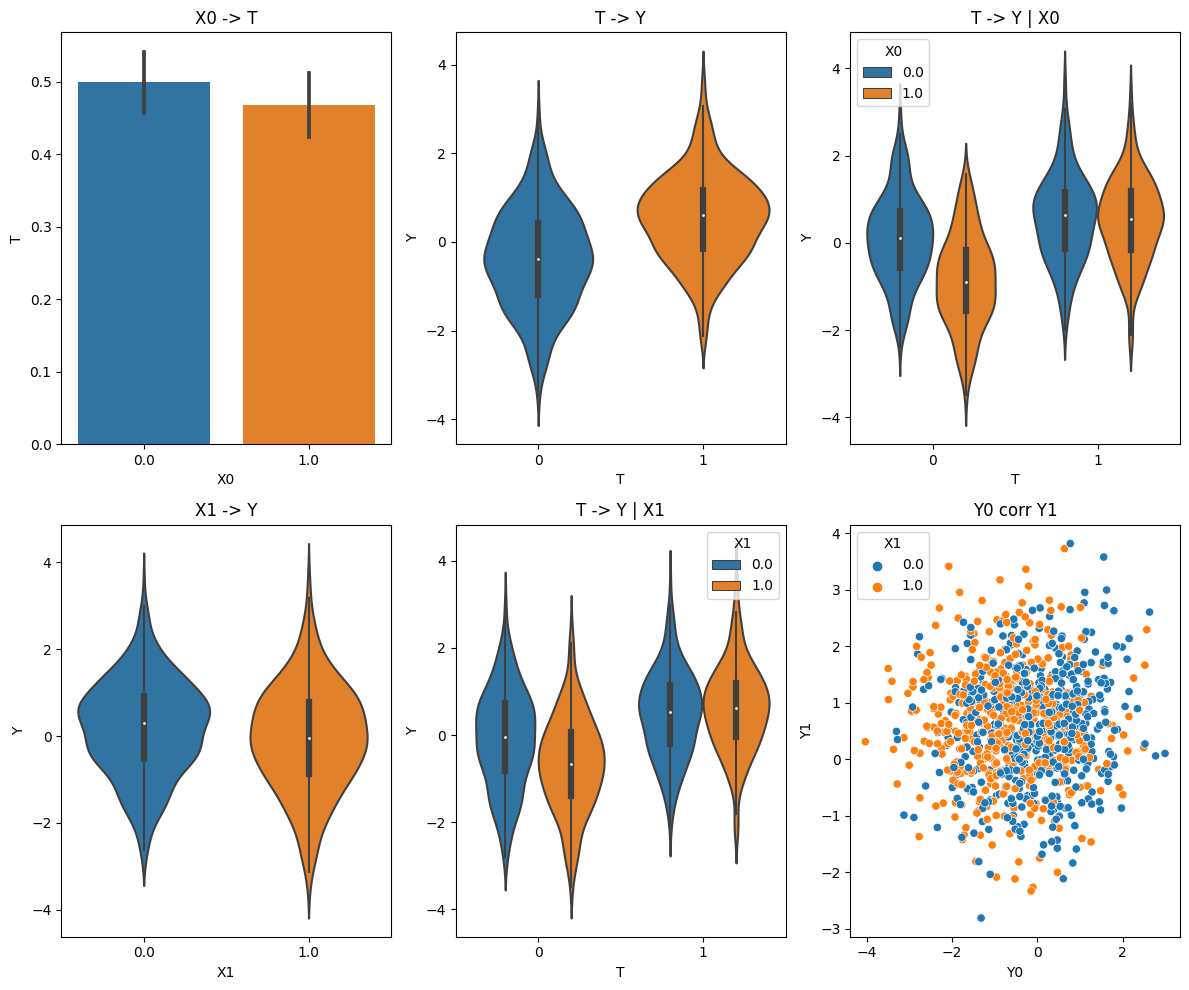

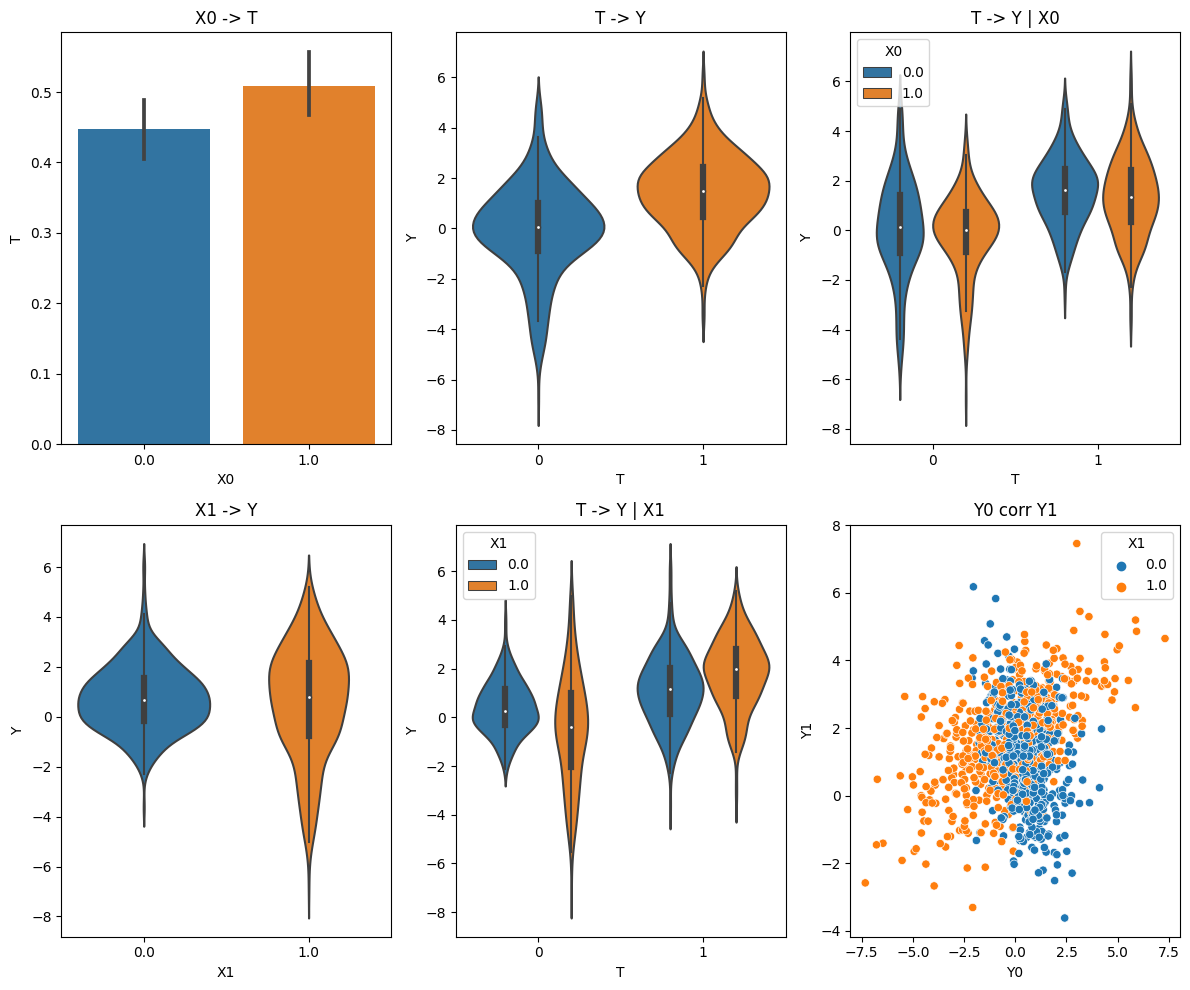

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as dist
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dimensionality of the treatment
k = 3  # k treatment groups and 1 control group

class PotentialNoiseNet(nn.Module):
    def __init__(self, p, num_treatments, disco=True):
        super().__init__()
        self.p = p
        self.num_treatments = num_treatments
        self.disco = disco
        self.fc_mu = nn.Linear(self.p, self.num_treatments)
        self.fc_sigma = nn.Linear(self.p, self.num_treatments * self.num_treatments)

    def forward(self, x):
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        sigma = sigma.view(-1, self.num_treatments, self.num_treatments)  # Reshape to a batch of matrices
        sigma = sigma + sigma.transpose(-1, -2)  # Make it symmetric
        sigma = torch.bmm(sigma, sigma.transpose(-1, -2))  # Make it positive-definite
        return mu, sigma

    def sample(self, x, disco=None):
        mu, sigma = self.forward(x)
        disco = disco if disco is not None else self.disco
        if disco:
            return dist.MultivariateNormal(mu, sigma).sample()
        else:
            return torch.randn((x.shape[0], num_treatments))

class AssignmentNet(nn.Module):
    def __init__(self, p, num_treatments, rct=False):
        super().__init__()
        self.p = p
        self.rct = rct
        self.num_treatments = num_treatments
        self.fc = nn.Linear(self.p, self.num_treatments)

    def forward(self, x, rct=None):
        logits = self.fc(x)
        rct = rct if rct is not None else self.rct
        if rct:
            logits = torch.ones_like(logits)
        return nn.functional.softmax(logits, dim=-1)  # Apply softmax to get probabilities

    def sample(self, *args, **kwargs):
        return dist.Categorical(self.forward(*args, **kwargs)).sample()

class PotentialOutcomeNet(nn.Module):
    def __init__(self, p, num_treatments):
        super().__init__()ujm mku7 555558e4
        self.p = p
        self.num_treatments = num_treatments
        self.fc_tau = nn.Linear(self.p, self.num_treatments)
        self.fc_b = nn.Linear(self.p, 1)

    def forward(self, x):
        return self.fc_tau(x), self.fc_b(x)

    def generate(self, x, epsilon):
        tau, b = self.forward(x)
        return tau  + b + epsilon

    def obs_outcome(self, x, t, epsilon):
        Y = self.generate(x, epsilon)
        return Y[torch.arange(Y.shape[0]), t]  # Indexing operation

class MultipleT4DiscoSCM(nn.Module):
    def __init__(self, num_treatments=2, p=2):
        super(MultipleT4DiscoSCM, self).__init__()
        self.num_treatments = num_treatments
        self.p = p
        self.potential_noise_net = PotentialNoiseNet(p, num_treatments)
        self.assignment_net = AssignmentNet(p, num_treatments)
        self.potential_outcome_net = PotentialOutcomeNet(p, num_treatments)

    def forward(self, x, t):
        epsilon = self.potential_noise_net.sample(x)
        y = self.potential_outcome_net.obs_outcome(x, epsilon)
        return y

    def generate(self, num_samples=5, x=None, full=False, rct=False, disco=True):
        if x is None:
            x = torch.randint(low=0, high=self.num_treatments, size=(num_samples, self.p)).float()
        epsilon = self.potential_noise_net.sample(x, disco=disco)
        t = self.assignment_net.sample(x, rct=rct)

        df = pd.DataFrame()
        for i in range(x.shape[1]):
            df[f'X{i}'] = x[:, i].numpy()
        df['T'] = t.numpy()

        if full:
            Y_full = self.potential_outcome_net.generate(x, epsilon)
            for i in range(Y_full.shape[1]):
                df[f'Y{i}'] = Y_full[:, i].data.numpy()
            df['Y'] = self.obs(Y_full.data, t)
        else:
            Y = self.potential_outcome_net.obs_outcome(x, t, epsilon)
            df['Y'] = Y.data.numpy()

        for i in range(epsilon.shape[1]):
            df[f'e{i}'] = epsilon[:, i]

        return df

    @staticmethod
    def obs(po, t):
        return po[torch.arange(po.shape[0]), t]

    @staticmethod
    def visualize(data, X='X0', T='T', Y='Y', W='X1', Y0='Y0', Y1='Y1'):

        # Create 2x3 subplot layout
        fig, axes = plt.subplots(2, 3, figsize=(12, 10))

        # Visualize X -> T
        sns.barplot(x=X, y=T, data=data, ax=axes[0, 0]) # , errorbar=None
        axes[0, 0].set_xlabel(X)
        axes[0, 0].set_ylabel(T)
        axes[0, 0].set_title(f'{X} -> {T}')

        # Visualize T -> Y
        sns.violinplot(x=T, y=Y, data=data, ax=axes[0, 1])
        axes[0, 1].set_xlabel(T)
        axes[0, 1].set_ylabel(Y)
        axes[0, 1].set_title(f'{T} -> {Y}')

        # Visualize T -> Y | X
        sns.violinplot(x=T, y=Y, hue=X, data=data, ax=axes[0, 2]) # , hue=X
        axes[0, 2].set_xlabel(T)
        axes[0, 2].set_ylabel(Y)
        axes[0, 2].set_title(f'{T} -> {Y} | {X}')

        # Visualize W -> Y
        sns.violinplot(x=W, y=Y, data=data, ax=axes[1, 0])
        axes[1, 0].set_xlabel(W)
        axes[1, 0].set_ylabel(Y)
        axes[1, 0].set_title(f'{W} -> {Y}')

        # Visualize T -> Y | W
        sns.violinplot(x=T, y=Y, hue=W, data=data, ax=axes[1, 1])
        axes[1, 1].set_xlabel(T)
        axes[1, 1].set_ylabel(Y)
        axes[1, 1].set_title(f'{T} -> {Y} | {W}')

        # Visualize Y0 corr Y1
        sns.scatterplot(x=Y0, y=Y1, hue=W, data=data, ax=axes[1, 2])
        axes[1, 2].set_xlabel(Y0)
        axes[1, 2].set_ylabel(Y1)
        axes[1, 2].set_title(f'{Y0} corr {Y1}')

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show plot
        plt.show()
# example usage
num_treatments = 2
p = 2
n = 1000

data_generator = MultipleT4DiscoSCM(num_treatments)
df = data_generator.generate(n, full=True, rct=True, disco=False)

print(df)
data_generator.visualize(df)

df = data_generator.generate(n, full=True, rct=True, disco=True)
data_generator.visualize(df)

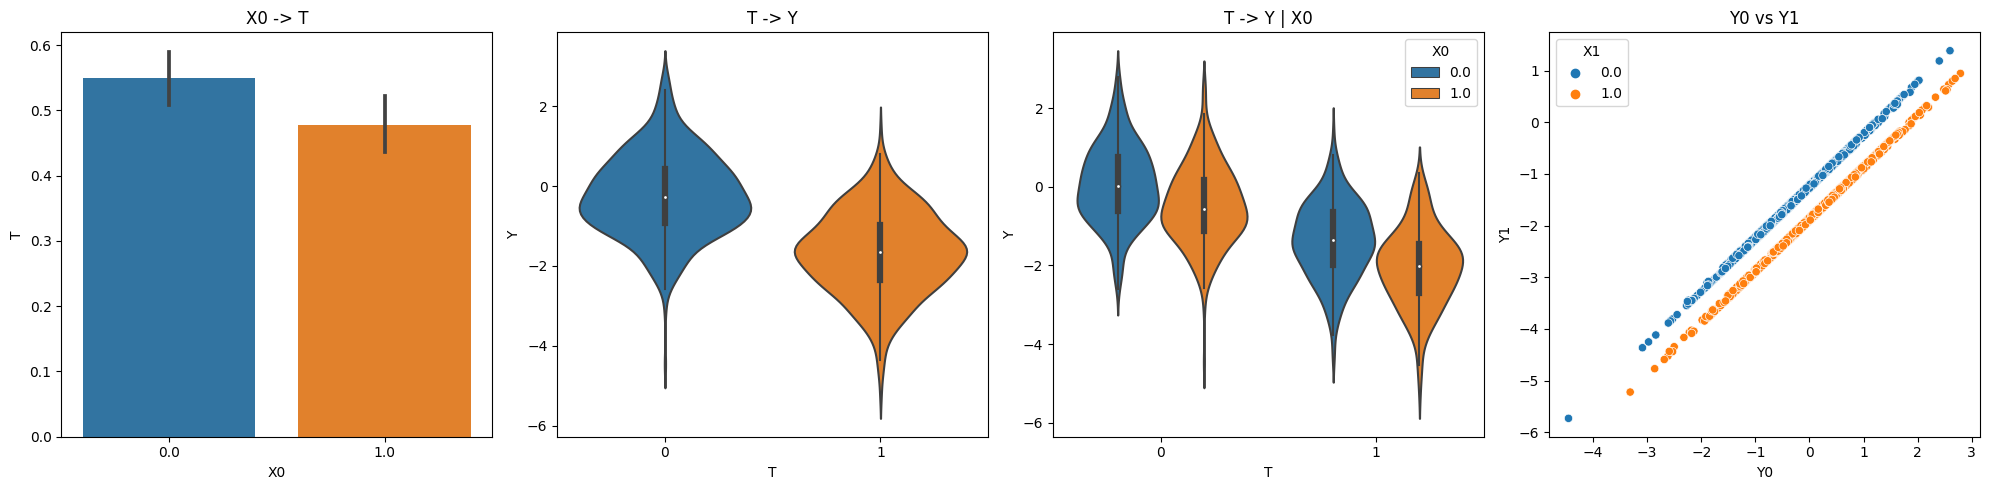

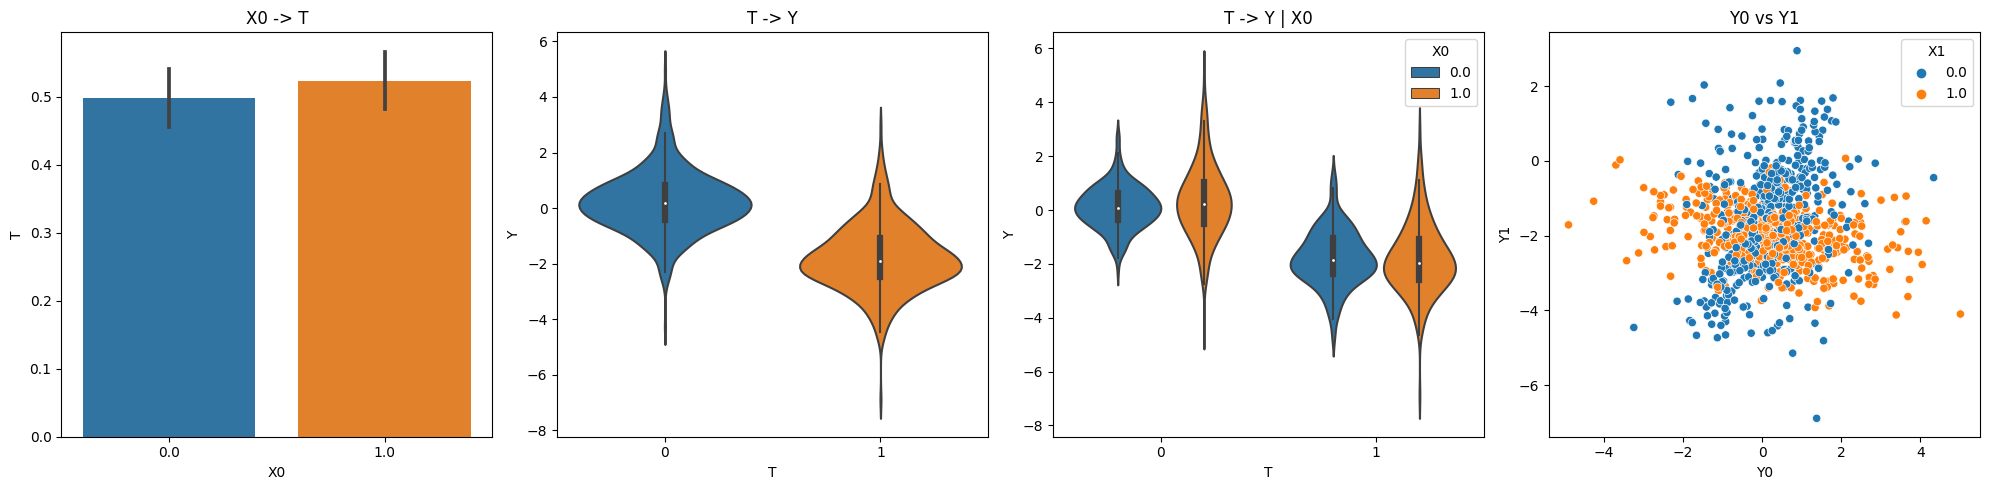

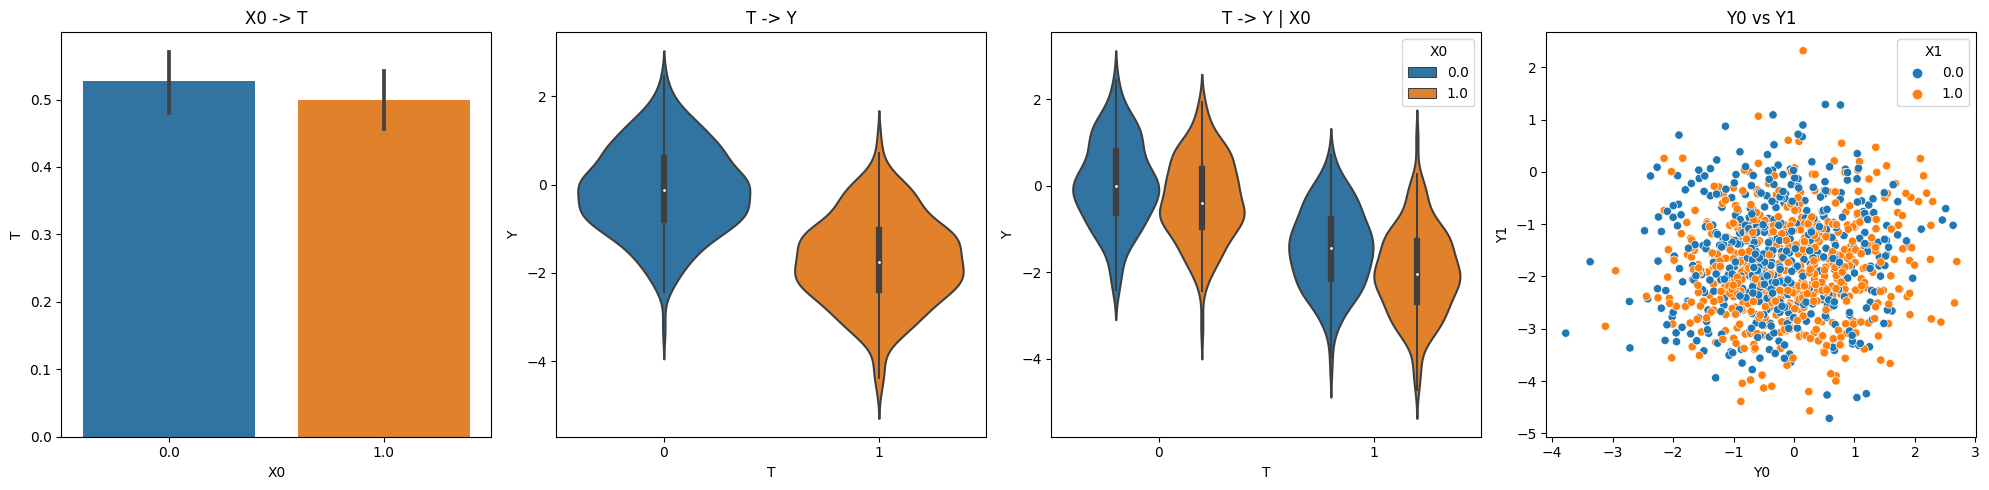

X0   X1  T        Y0        Y1         Y        e0        e1
0    0.0  0.0  0  2.453181 -0.919549  2.453181  2.522858  0.363424
1    1.0  1.0  1 -1.294264 -3.261259 -3.261259 -1.028726 -1.086056
2    0.0  1.0  1 -1.166537 -0.416756 -0.416756 -1.415110  1.179307
3    0.0  0.0  0  1.413350 -2.273797  1.413350  1.483027 -0.990824
4    0.0  0.0  1 -1.926483 -1.028573 -1.028573 -1.856805  0.254399
..   ...  ... ..       ...       ...       ...       ...       ...
995  1.0  1.0  1  0.266826 -1.860682 -1.860682  0.532363  0.314520
996  1.0  0.0  1 -0.892009 -2.372771 -2.372771 -0.308221 -0.510659
997  1.0  0.0  1 -0.673505 -0.067251 -0.067251 -0.089718  1.794861
998  1.0  0.0  0 -0.968234 -1.721370 -0.968234 -0.384447  0.140742
999  1.0  1.0  1 -0.786252 -1.281929 -1.281929 -0.520715  0.893273

[1000 rows x 8 columns]

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as dist
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dimensionality of the treatment
k = 3  # k treatment groups and 1 control group

class PotentialNoiseNet(nn.Module):
    def __init__(self, p, num_treatments, disco=True):
        super().__init__()
        self.p = p
        self.num_treatments = num_treatments
        self.disco = disco
        self.fc_mu = nn.Linear(self.p, self.num_treatments)
        self.fc_sigma = nn.Linear(self.p, self.num_treatments * self.num_treatments)

    def forward(self, x):
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        sigma = sigma.view(-1, self.num_treatments, self.num_treatments)  # Reshape to a batch of matrices
        sigma = sigma + sigma.transpose(-1, -2)  # Make it symmetric
        sigma = torch.bmm(sigma, sigma.transpose(-1, -2))  # Make it positive-definite
        return mu, sigma

    def sample(self, x, disco=None):
        out = None
        disco = disco if disco is not None else self.disco
        if disco==0:
            out = torch.randn(x.shape[0], 1).repeat(1, self.num_treatments)
        elif disco==1:
            mu, sigma = self.forward(x)
            out = dist.MultivariateNormal(mu, sigma).sample()
        elif disco==2:
            out = torch.randn((x.shape[0], self.num_treatments))
        else:
            print(f'Invalid Parameter Value {disco} for disco')

        return out

class AssignmentNet(nn.Module):
    def __init__(self, p, num_treatments, rct=False):
        super().__init__()
        self.p = p
        self.rct = rct
        self.num_treatments = num_treatments
        self.fc = nn.Linear(self.p, self.num_treatments)

    def forward(self, x, rct=None):
        logits = self.fc(x)
        rct = rct if rct is not None else self.rct
        if rct:
            logits = torch.ones_like(logits)
        return nn.functional.softmax(logits, dim=-1)  # Apply softmax to get probabilities

    def sample(self, *args, **kwargs):
        return dist.Categorical(self.forward(*args, **kwargs)).sample()

class PotentialOutcomeNet(nn.Module):
    def __init__(self, p, num_treatments):
        super().__init__()
        self.p = p
        self.num_treatments = num_treatments
        self.fc_tau = nn.Linear(self.p, self.num_treatments)
        self.fc_b = nn.Linear(self.p, 1)

    def forward(self, x):
        return self.fc_tau(x), self.fc_b(x)

    def generate(self, x, epsilon):
        tau, b = self.forward(x)
        return tau  + b + epsilon

    def obs_outcome(self, x, t, epsilon):
        Y = self.generate(x, epsilon)
        return Y[torch.arange(Y.shape[0]), t]  # Indexing operation

class MultipleT4DiscoSCM(nn.Module):
    def __init__(self, num_treatments=2, p=2):
        super(MultipleT4DiscoSCM, self).__init__()
        self.num_treatments = num_treatments
        self.p = p
        self.potential_noise_net = PotentialNoiseNet(p, num_treatments)
        self.assignment_net = AssignmentNet(p, num_treatments)
        self.potential_outcome_net = PotentialOutcomeNet(p, num_treatments)

    def forward(self, x, t):
        epsilon = self.potential_noise_net.sample(x)
        y = self.potential_outcome_net.obs_outcome(x, epsilon)
        return y

    def quickstart(self, *args, **kwargs):
        df = self.generate(*args, **kwargs)
        self.visualize(df)
        return df

    def generate(self, num_samples=5, x=None, full=False, rct=False, disco=True):
        if x is None:
            x = torch.randint(low=0, high=self.num_treatments, size=(num_samples, self.p)).float()
        epsilon = self.potential_noise_net.sample(x, disco=disco)
        t = self.assignment_net.sample(x, rct=rct)

        df = pd.DataFrame()
        for i in range(x.shape[1]):
            df[f'X{i}'] = x[:, i].numpy()
        df['T'] = t.numpy()

        if full:
            Y_full = self.potential_outcome_net.generate(x, epsilon)
            for i in range(Y_full.shape[1]):
                df[f'Y{i}'] = Y_full[:, i].data.numpy()
            df['Y'] = self.obs(Y_full.data, t)
        else:
            Y = self.potential_outcome_net.obs_outcome(x, t, epsilon)
            df['Y'] = Y.data.numpy()

        for i in range(epsilon.shape[1]):
            df[f'e{i}'] = epsilon[:, i]

        return df

    @staticmethod
    def obs(po, t):
        return po[torch.arange(po.shape[0]), t]

    @staticmethod
    def visualize_detail(data, X='X0', T='T', Y='Y', W='X1', Y0='Y0', Y1='Y1'):

        # Create 2x3 subplot layout
        fig, axes = plt.subplots(2, 3, figsize=(12, 10))

        # Visualize X -> T
        sns.barplot(x=X, y=T, data=data, ax=axes[0, 0]) # , errorbar=None
        axes[0, 0].set_xlabel(X)
        axes[0, 0].set_ylabel(T)
        axes[0, 0].set_title(f'{X} -> {T}')

        # Visualize T -> Y
        sns.violinplot(x=T, y=Y, data=data, ax=axes[0, 1])
        axes[0, 1].set_xlabel(T)
        axes[0, 1].set_ylabel(Y)
        axes[0, 1].set_title(f'{T} -> {Y}')

        # Visualize T -> Y | X
        sns.violinplot(x=T, y=Y, hue=X, data=data, ax=axes[0, 2]) # , hue=X
        axes[0, 2].set_xlabel(T)
        axes[0, 2].set_ylabel(Y)
        axes[0, 2].set_title(f'{T} -> {Y} | {X}')

        # Visualize W -> Y
        sns.violinplot(x=W, y=Y, data=data, ax=axes[1, 0])
        axes[1, 0].set_xlabel(W)
        axes[1, 0].set_ylabel(Y)
        axes[1, 0].set_title(f'{W} -> {Y}')

        # Visualize T -> Y | W
        sns.violinplot(x=T, y=Y, hue=W, data=data, ax=axes[1, 1])
        axes[1, 1].set_xlabel(T)
        axes[1, 1].set_ylabel(Y)
        axes[1, 1].set_title(f'{T} -> {Y} | {W}')

        # Visualize Y0 corr Y1
        sns.scatterplot(x=Y0, y=Y1, hue=W, data=data, ax=axes[1, 2])
        axes[1, 2].set_xlabel(Y0)
        axes[1, 2].set_ylabel(Y1)
        axes[1, 2].set_title(f'{Y0} corr {Y1}')

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show plot
        plt.show()

    @staticmethod
    def visualize(data, X='X0', T='T', Y='Y', W='X1', Y0='Y0', Y1='Y1'):
        # Create 1x4 subplot layout
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Visualize X -> T
        sns.barplot(x=X, y=T, data=data, ax=axes[0])
        axes[0].set_xlabel(X)
        axes[0].set_ylabel(T)
        axes[0].set_title(f'{X} -> {T}')

        # Visualize T -> Y
        sns.violinplot(x=T, y=Y, data=data, ax=axes[1])
        axes[1].set_xlabel(T)
        axes[1].set_ylabel(Y)
        axes[1].set_title(f'{T} -> {Y}')

        # Visualize T -> Y | X
        sns.violinplot(x=T, y=Y, hue=X, data=data, ax=axes[2])
        axes[2].set_xlabel(T)
        axes[2].set_ylabel(Y)
        axes[2].set_title(f'{T} -> {Y} | {X}')

        # Visualize Y0 corr Y1
        sns.scatterplot(x=Y0, y=Y1, hue=W, data=data, ax=axes[3])
        axes[3].set_xlabel(Y0)
        axes[3].set_ylabel(Y1)
        axes[3].set_title(f'{Y0} vs {Y1}')

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show plot
        plt.show()


# example usage
num_treatments = 2
p = 2
n = 1000

data_generator = MultipleT4DiscoSCM(num_treatments)
data_generator.quickstart(n, full=True, rct=True, disco=0)
data_generator.quickstart(n, full=True, rct=True, disco=1)
data_generator.quickstart(n, full=True, rct=True, disco=2)


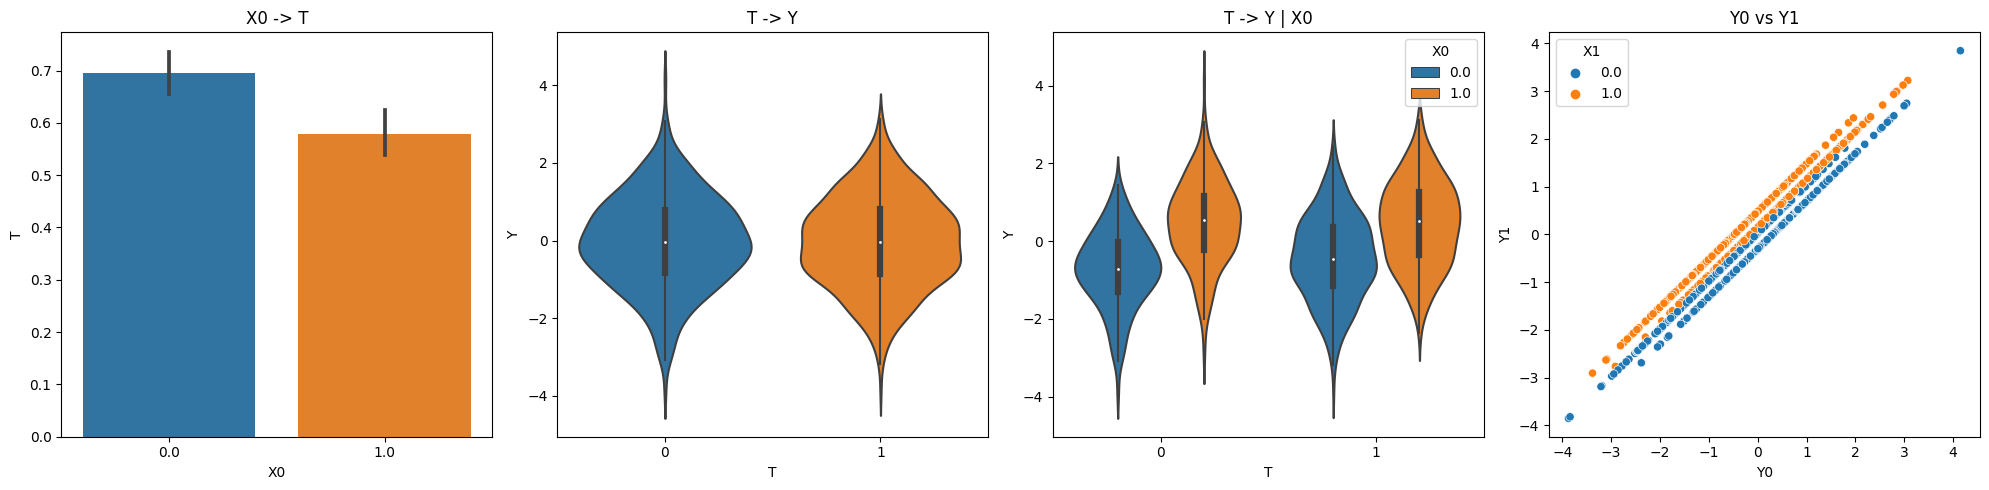

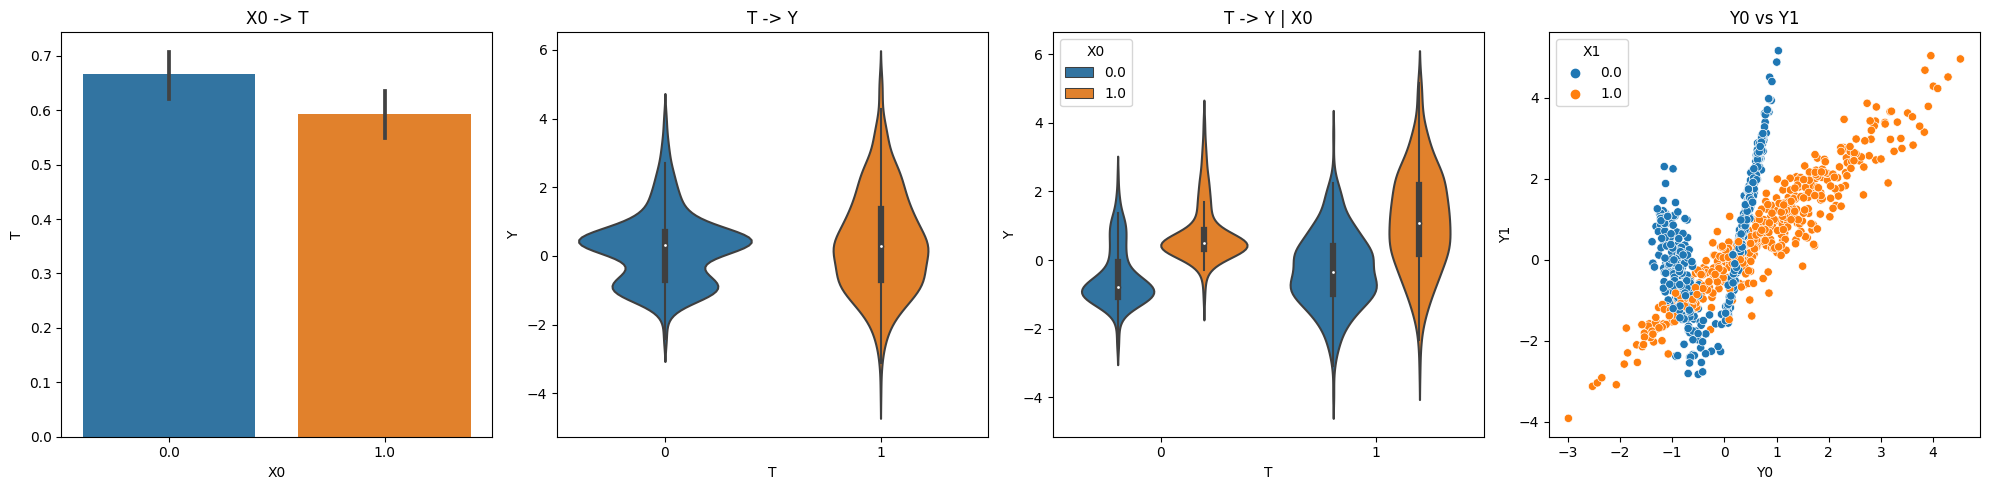

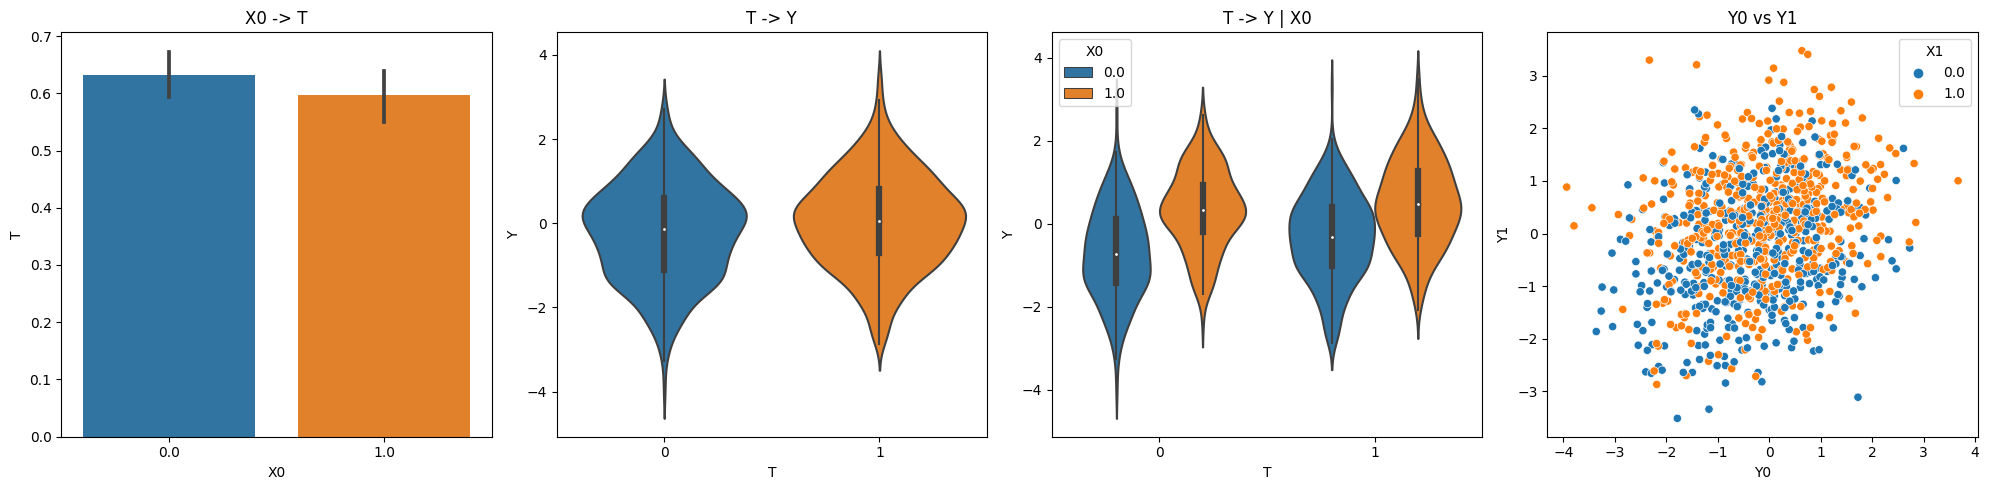

X0   X1  T        Y0        Y1         Y        e0        e1
0    1.0  1.0  0  0.337482  1.521211  0.337482 -0.202352  0.832398
1    0.0  0.0  1  0.196006 -1.053090 -1.053090  1.029269 -0.242259
2    0.0  1.0  1 -2.216899  0.047150  0.047150 -1.580783  0.205818
3    1.0  0.0  0  0.333345 -1.005865  0.333345 -0.009343 -1.042516
4    1.0  0.0  1 -0.461273  0.891637  0.891637 -0.803961  0.854986
..   ...  ... ..       ...       ...       ...       ...       ...
995  0.0  1.0  1 -0.064464 -1.248782 -1.248782  0.571652 -1.090114
996  0.0  1.0  1  0.069296  0.288377  0.288377  0.705413  0.447045
997  1.0  0.0  0 -0.404595  1.079586 -0.404595 -0.747283  1.042935
998  0.0  1.0  1 -1.615061 -1.529959 -1.529959 -0.978945 -1.371291
999  1.0  0.0  1 -0.361916  0.542724  0.542724 -0.704603  0.506073

[1000 rows x 8 columns]

In [ ]:
data_generator = MultipleT4DiscoSCM(num_treatments)
data_generator.quickstart(n, full=True, rct=False, disco=0)
data_generator.quickstart(n, full=True, rct=False, disco=1)
data_generator.quickstart(n, full=True, rct=False, disco=2)